In [1]:
%pylab inline
import os
import time
import glob
import operator
import xarray as xr
import numpy as np
import math
import itertools
import summa_plot as sp
import pysumma.Simulation
import scipy.stats
import matplotlib as mpl
from pprint import pprint
from functools import reduce
from scipy.special import psi, inv_boxcox
#from jupyterthemes import jtplot
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import importlib
from jupyterthemes import jtplot
importlib.reload(pysumma.Simulation)

jtplot.style('grade3', fscale=1.6)
jtplot.figsize(x=36, y=20)
mpl.rcParams['figure.figsize'] = (18, 10)

MM_PER_M = 1000
SEC_PER_MIN = 60
MIN_PER_HOUR = 60
HOUR_PER_DAY = 24
DAY_PER_YEAR = 365
# Timestep is 1 hour in our case
SEC_PER_TIMESTEP = SEC_PER_MIN * MIN_PER_HOUR

user = os.environ['USER']
sites = ['Amplero', 'Blodgett', 'Bugac', 'ElSaler', 'ElSaler2', 'Espirra', 'FortPeck', 
         'Harvard', 'Hesse', 'Howard', 'Howlandm', 'Hyytiala', 'Kruger', 'Loobos', 'Merbleue',
         'Mopane', 'Palang', 'Sylvania', 'Tumba', 'UniMich']
soil_moisture_sites = ['Amplero', 'Blodgett', 'ElSaler', 'ElSaler2', 'FortPeck', 'Hesse', 
                       'Hyytiala', 'Loobos', 'Mopane', 'Sylvania']
final_sites = ['Blodgett', 'ElSaler', 'ElSaler2', 'FortPeck', 'Hesse', 
                       'Hyytiala', 'Loobos', 'Sylvania']
fman_template = "/pool0/data/"+user+"/PLUMBER_data/sites/{}/settings/summa_zFileManager_{}.txt"
oc_template = "/pool0/data/"+user+"/PLUMBER_data/sites/{}/settings/meta/summa_zModelOutput.txt"
fman_dict = {s: fman_template.format(s, s) for s in sites}

wb_vars = ['pptrate', 'scalarGroundEvaporation', 'scalarCanopyEvaporation',
           'scalarSnowSublimation', 'scalarCanopySublimation', 'scalarTotalRunoff', 
           'scalarSWE', 'scalarTotalSoilLiq',  'scalarTotalSoilIce', 
           'scalarCanopyIce', 'scalarCanopyLiq', 'scalarCanopyTranspiration', 
           'scalarLatHeatTotal', 'scalarSenHeatTotal', 'airtemp', 'SWRadAtm']

wb_dict = {
    'precip': ['pptrate'],
    'evap': ['scalarGroundEvaporation', 'scalarCanopyEvaporation', 'scalarCanopyTranspiration', 
             'scalarSnowSublimation', 'scalarCanopySublimation'],
    'runoff': ['scalarTotalRunoff'],
    'swe': ['scalarSWE'],
    'soil_moisture': ['scalarTotalSoilLiq', 'scalarTotalSoilIce'],
    'canopy_moisture': ['scalarCanopyIce', 'scalarCanopyLiq'],
    'latent_heat': ['scalarLatHeatTotal'],
    'sensible_heat': ['scalarSenHeatTotal'],
    'temperature': ['airtemp'],
    'shortwave': ['SWRadAtm']
}

wb_multiplier = {
    'precip': SEC_PER_TIMESTEP,
    'evap': SEC_PER_TIMESTEP,
    'runoff': SEC_PER_TIMESTEP * MM_PER_M,
    'swe': 1,
    'soil_moisture': 1,
    'canopy_moisture': 1,
    'latent_heat': -1,
    'sensible_heat': -1,
    'temperature': 1,
    'shortwave': 1
}

def raw_data(data_array):
    """Unpacks data into a flat array"""
    eps = 1e-12
    return data_array.values.flatten() + eps * np.random.random(data_array.shape)


def good_inds(x, strict=False):
    """Remove invalid data"""
    if strict:
        return np.where(np.logical_and(x > 1e-10, x < 3000))[0]
    return np.where(np.logical_and(x > -3000, x < 3000))[0]

def good_data(x, strict=False):
    return x[good_inds(x, strict=strict)]

def nearest_distances(X, k=1):
    """Compute distances to kth nearest neighbors"""
    knn = NearestNeighbors(n_neighbors=k, metric='chebyshev')
    knn.fit(X)
    d, _ = knn.kneighbors(X)
    return d[:, -1]


def marginal_neighbors(X, R):
    """Compute number of neighbors in R-radius ball"""
    knn = NearestNeighbors(metric='chebyshev')
    knn.fit(X)
    return np.array([len(knn.radius_neighbors(p.reshape(1, -1), r)[0][0])
                     for p, r in zip(X, R)])


def entropy_sk(X, k=False):
    """Compute entropy H(X1, X2,..., Xn)"""
    try:
        n, d = X.shape
    except Exception as e:
        X = X.reshape(-1, 1)
        n, d = X.shape
    if not k:
        k = 10#int(np.sqrt(n))
    eps = 1e-12
    r = nearest_distances(X, k) + eps * np.random.random(n)
    n, d = X.shape
    ent = d * np.log(np.mean(r)) + psi(n) - psi(k) + d * np.log(2)
    return ent


def mutual_info(x, y, k=False):
    """Compute I(X; Y)"""
    n = len(x)
    if not k:
        k = 10#int(np.sqrt(n))
    eps = 1e-12
    r = nearest_distances(np.array([x, y]).T, k) + eps * np.random.random(n)
    n_x = marginal_neighbors(x.reshape(-1,1), r)
    n_y = marginal_neighbors(y.reshape(-1,1), r)
    psi_x = psi(n_x)
    psi_y = psi(n_y)
    return (psi(n) + psi(k) - (1./k) - np.mean(psi_x + psi_y))


def conditional_mutual_info(X, k=False):
    """Compute I(X1; X2 | X3:n)"""
    xz = np.array([X[0], *X[2:]]).T
    yz = np.array([X[1], *X[2:]]).T
    z = np.array(X[2:]).T
    d, n = X.shape
    if not k:
        k = 10
    eps = 1e-12
    r = nearest_distances(X.T, k) + eps * np.random.random(n)
    n_xz = marginal_neighbors(xz, r)
    n_yz = marginal_neighbors(yz, r)
    n_z = marginal_neighbors(z, r)
    psi_xz = psi(n_xz)
    psi_yz = psi(n_yz)
    psi_z = psi(n_z)
    return psi(k) - np.mean(psi_xz + psi_yz - psi_z)
    #return (psi(k) - (2./k) - np.mean(-psi_z + psi_xz + psi_yz - (1/n_xz) - (1/n_yz)))

def transfer_entropy(X: np.array, lag: int, window: int) -> float:
    """
    Computes TE(X2_t; X1_{t-lag} | X2_{t-lag})

    Args:
        X: A list containing multiple timeseries.
           Example: [evap, precip] will compute
           the information transferred from precip to evap,
        lag: The time-offset to consider (in timesteps).

    Returns:
        The value of the equation given above.  Small values
        denote less of a connection.  Negative values are
        possible, but should be thrown out - as they are
        numerical artifacts.
    """
    assert len(X) == 2
    # Subsample data and put it together with combination list
    sample_size = np.min([5000, len(X[0])-lag-window])
    max_start = len(X[0]) - sample_size - lag - window
    idx = np.random.choice(np.arange(lag+window, len(X[0])) - lag - window, sample_size)
    cmis = []
    for w in range(window):
        ans = [X[1][idx]]
        ans.append(X[0][idx-w-lag])
        ans.append(X[1][idx-1])
        cmis.append(conditional_mutual_info(np.array(ans)))
    return np.sum(cmis)
   

def conditional_transfer_entropy(X: np.array, lag: int, window: int) -> float:
    """
    Computes TE(X1_t; X2_{t-lag} | X3:n_{t-lag}, X1_{t-lag})

    Args:
        X: A list containing multiple timeseries.
           Example: [evap, precip, runoff] will compute
           the information transferred from precip to evap,
           eliminating any effects from runoff.
        lag: The time-offset to consider (in days).

    Returns:
        The value of the equation given above.  Small values
        denote less of a connection.  Negative values are
        possible, but should be thrown out - as they are
        numerical artifacts.
    """
    # Need at least 3 variables to compute the TE
    assert len(X) > 2
    # Subsample data and put it together with combination list
    sample_size = np.min([5000, len(X[0])-lag-window])
    max_start = len(X[0]) - sample_size - lag - window
    idx = np.random.choice(np.arange(lag+window, len(X[0])), sample_size)
    cmis = []
    for w in range(window):
        ans = [X[1][idx]]
        ans.append(X[0][idx-w-lag])
        for v in X[2:]:
            ans.append(v[idx-w-lag])
        ans.append(X[1][idx-1])
        cmis.append(conditional_mutual_info(np.array(ans)))
    return np.sum(cmis)


def mutual_info_analysis_full_lagged(ds, out_name, lag=0, window=3, sample_size=3000):
    """
    Compute the mutual information or transfer entropy of variables of
    interest for a dataset.  
    """
    precip = raw_data(ds['precip'])
    temp = raw_data(ds['temperature'])
    soil_moist = raw_data(ds['soil_moisture'])
    lat_heat = raw_data(ds['latent_heat'])
    sen_heat = raw_data(ds['sensible_heat'])
    swrad = raw_data(ds['shortwave'])
    
    names = ['precipitation', 'temperature', 'soil_moisture', 'latent_heat', 'sensible_heat', 'shortwave']
    varlist = [precip, temp, soil_moist, lat_heat, sen_heat, swrad]
    good_data = reduce(np.intersect1d, [good_inds(v) for v in varlist])
    varlist = np.array([v[good_data] for v in varlist])
    
    # Compute indices for subsampling
    sample_size = np.min([sample_size, len(varlist[0])-lag])
    idx = np.random.choice(np.arange(len(varlist[0])-lag), sample_size, replace=False)+lag
    
    # Calculate all needed variable combinations
    mapping = {n: d for n, d in zip(names, varlist)}
    permutations = [list(l) for l in list(itertools.permutations(names, 2))]
    for combo in permutations:
        n = [n for n in names if n not in combo ]
        [combo.append(nn) for nn in n]   
        
    # Subsample data and put it together with combination list
    analysis_sets = []
    for combo in permutations:
        analysis_sets.append([mapping[c] for c in combo])
    
    # Compute scores
    scores = []
    for c, s in zip(permutations, analysis_sets):
        scores.append(conditional_transfer_entropy(s, lag, window))
       
    # Reformat into a nice dataframe, save it, and return
    df = pd.DataFrame(columns=names, index=names)
    for link, score in zip(permutations, scores):
        if score < 1e-6:
            score = 0
        d = {'name_x': link[0], 'name_y': link[1], 'value': score}
        df.loc[link[0], link[1]] = score
    for name, var in zip(names, varlist):
        e_tot = entropy_sk(var[idx])
        #print('computing unexplained entropy for {}: {}'.format(name, e_tot))
        e_tot -= df[name].sum(skipna=True)
        df[name][name] = e_tot
    df.to_csv('../data/{}.csv'.format(out_name))
    return df

def postprocess(ds):
    """
    Aggregate subcomponents and convert units for the
    output variables of interest. This also removes
    the unnecessary hru dimension
    """
    for k, v in wb_dict.items():
        ds[k] = reduce(operator.add, [ds[vv] for vv in v]) * wb_multiplier[k]
    ds = ds[list(wb_dict.keys())].isel(hru=0, drop=True)
    ds['dswe'] = ds['swe']
    ds['dsoil_moisture'] = ds['soil_moisture'].diff(dim='time')
    return ds

def rmse(da1, da2):
    return np.sqrt(np.mean(np.power(da1-da2,2))).values

def mbe(da1, da2):
    return (np.sum(da1-da2) / len(da1.values)).values

def r(da1, da2):
    return scipy.stats.pearsonr(da1.values.flatten(),
                                da2.values.flatten())[0]

def dtw(da1, da2):
    return fastdtw(da1.values.flatten(), da2.values.flatten())[0]

Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_name(file):
    '''
    extracts the combinations from a summa output file
    probably could be done much better with a regular
    expression
    '''
    return file.split('summa_output/')[1].split('_timestep.nc')[0]

def get_site_name(file):
    '''
    extracts the combinations from a summa output file
    probably could be done much better with a regular
    expression
    '''
    return file.split('summa_output/')[1].split('_')[0]

def get_configuration(file):
    '''
    extracts the configuration from a summa output file
    '''
    return get_name(file).split(get_site_name(file) + '_output_')[1].split('_')

In [3]:
out_files = []
for site in soil_moisture_sites:
    out_files += glob.glob('/pool0/data/tushark/PLUMBER_data/sites/' + site + '/summa_output/*output*.nc', recursive=True)

In [4]:
def find_distance(x, y):
    #find square of differences
    squares = np.square(x-y)
    return math.sqrt(sum(squares))

In [7]:
# abandoned
def compute_values_for_dict(summa_output_dict):
    result = pd.DataFrame(columns=['Site', 'Configuration', 'rmse_Qle', 'mbe_Qle', 'd_Qle', 'rmse_Qh', 'mbe_Qh', 'd_Qh'])
    for site in summa_output_dict:
            for file in summa_output_dict[site]:
                output = xr.open_dataset(file)
                obs_path = '/pool0/data/andrbenn/PLUMBER_data/sites/{}/observations/fluxes/{}Fluxnet.1.4_flux.nc'.format(site, site)
                obs = xr.open_dataset(obs_path)
                mi_path = '/pool0/data/tushark/pysumma/data/' + get_name(file) + '.csv'
                obs_mi_path = '/pool0/data/andrbenn/PLUMBER_data/data/' + get_site_name() + '_obs_0_10.csv'
                obs_mi = pd.read_csv(obs_mi_path)
                output_mi = pd.read_csv(output_mi_path)
                rmse_Qle = rmse(output['latent_heat'], obs['Qle'])
                rmse_Qh = rmse(out['sensible_heat'], obs['Qh'])
                d_Qle = find_distance(obs_mi['latent_heat'], output_mi(['latent_heat']))
                d_Qh = find_distance(obs_mi['sensible_heat'], output_mi(['sensible_heat']))
                mbe_Qle = mbe(output['latent_heat'], obs['Qle'])
                mbe_Qh = mbe(out['sensible_heat'], obs['Qh'])
                config = get_configuration(file)
                
                next_row = {'Site': site, 'Configuration': config, 'rmse_Qle': rmse_Qle, 
                            'mbe_Qle': mbe_Qle, 'd_Qle': d_Qle, 'rmse_Qh': rmse_Qh, 
                            'mbe_Qh': mbe_Qh'd_Qh': d_Qh}
                result.append(next_row, ignore_index = True)
                

In [31]:
def compute_values_for_list(output_file_list):
    result = pd.DataFrame(columns=['Site', 'Configuration', 'rmse_Qle', 
                                   'mbe_Qle', 'd_Qle', 'rmse_Qh', 'mbe_Qh', 'd_Qh'])
    dict_list = []
    for file in output_file_list:
        
        # find paths
        site = get_site_name(file)
        obs_path = '/pool0/data/andrbenn/PLUMBER_data/sites/{}/observations/fluxes/{}Fluxnet.1.4_flux.nc'.format(site, site)
        obs = xr.open_dataset(obs_path)
        output_mi_path = '/pool0/data/tushark/pysumma/data/' + get_name(file) + '.csv'
        obs_mi_path = '/pool0/data/andrbenn/PLUMBER_data/data/' + site + '_obs_0_10.csv'
        
        # create data structures
        output = xr.open_dataset(file)
        obs_mi = pd.read_csv(obs_mi_path)
        output_mi = pd.read_csv(output_mi_path)
        
        #calculate values
        rmse_Qle = rmse(output['scalarLatHeatTotal'], obs['Qle'])
        rmse_Qh = rmse(output['scalarSenHeatTotal'], obs['Qh'])
        
        #print(obs_mi['latent_heat'], output_mi(['latent_heat']))
        d_Qle = math.sqrt(sum(np.square(obs_mi['latent_heat']-output_mi['latent_heat'])))
        #find_distance(obs_mi['latent_heat'], output_mi(['latent_heat']))
        d_Qh = math.sqrt(sum(np.square(obs_mi['sensible_heat']-output_mi['sensible_heat'])))
        
        mbe_Qle = mbe(output['scalarLatHeatTotal'], obs['Qle'])
        mbe_Qh = mbe(output['scalarSenHeatTotal'], obs['Qh'])
        #find_distance(obs_mi['sensible_heat'], output_mi(['sensible_heat']))
        config = get_configuration(file)
        
        #add to dataframe
        next_row = {'Site': site, 'Configuration': config, 'rmse_Qle': rmse_Qle, 
                    'mbe_Qle': mbe_Qle, 'd_Qle': d_Qle, 'rmse_Qh': rmse_Qh, 
                    'mbe_Qh': mbe_Qh, 'd_Qh': d_Qh}
        dict_list.append(next_row)
        #result = result.append(next_row, ignore_index = True)
    
    #result = 
    result = result.append(dict_list, ignore_index=True)
    return result    

In [32]:
table = compute_values_for_list(out_files)

In [5]:
table = pd.read_csv('../data/may7.csv')

In [34]:
table.to_csv('../data/may7.csv')

In [6]:
table1 = table[8:64]

In [7]:
table2 = table1.append(table[:72])

In [8]:
table2

,Unnamed: 0,Site,Configuration,rmse_Qle,mbe_Qle,d_Qle,rmse_Qh,mbe_Qh,d_Qh
8,8,Blodgett,"['difTrans', 'logBelowCanopy', 'BallBerry']",148.598352,-26.839952,0.667725,270.651898,-38.731576,0.784271
9,9,Blodgett,"['difTrans', 'exponential', 'BallBerry']",149.279860,-27.090672,0.696839,270.405863,-38.695676,0.813544
10,10,Blodgett,"['simplExp', 'logBelowCanopy', 'BallBerry']",148.454869,-26.943737,0.823305,268.972269,-38.290527,0.760741
11,11,Blodgett,"['difTrans', 'logBelowCanopy', 'Jarvis']",166.757977,-29.805125,0.807682,260.961871,-36.058054,0.687893
12,12,Blodgett,"['simplExp', 'logBelowCanopy', 'Jarvis']",166.131683,-29.785172,0.898066,259.753533,-35.739190,0.702926
13,13,Blodgett,"['simplExp', 'exponential', 'BallBerry']",149.228513,-27.211130,0.633418,268.660818,-38.253460,0.732746
14,14,Blodgett,"['difTrans', 'exponential', 'Jarvis']",167.346079,-30.000456,0.897563,260.911049,-36.065983,0.728151
15,15,Blodgett,"['simplExp', 'exponential', 'Jarvis']",166.851532,-30.006284,0.958364,259.666103,-35.754814,0.760995
16,16,ElSaler,"['difTrans', 'exponential', 'Jarvis']",145.442303,-27.666198,1.207089,344.610981,-45.356733,0.677306
17,17,ElSaler,"['simplExp', 'exponential', 'Jarvis']",145.334282,-27.696713,1.119603,344.074976,-45.216099,0.628075


In [36]:
site = 'Hesse'
obs_path = '/pool0/data/andrbenn/PLUMBER_data/sites/{}/observations/fluxes/{}Fluxnet.1.4_flux.nc'.format(site, site)
obs_path
obs_mi = pd.read_csv(obs_mi_path)
obs_mi

,Unnamed: 0,precipitation,temperature,soil_moisture,latent_heat,sensible_heat,shortwave
0,precipitation,1.699309,0.000000,0.000000,0.000000,0.000000,0.000000
1,temperature,0.000000,3.774171,0.000000,0.128078,0.247731,0.000000
2,soil_moisture,0.000000,0.000000,3.210738,0.000000,0.000000,0.000000
3,latent_heat,0.000000,0.000000,0.000000,5.342962,0.210373,0.132302
4,sensible_heat,0.000000,0.000000,0.000000,0.321249,5.509591,0.459294
5,shortwave,0.000000,0.000000,0.000000,0.295059,0.386932,6.220814


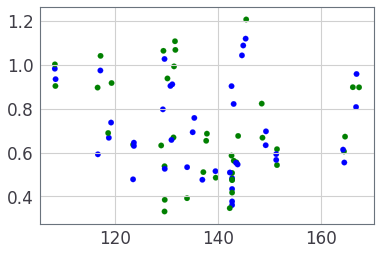

In [5]:
mpl.pyplot.scatter(table['rmse_Qle'], table['d_Qle'], color=['green', 'blue'])

In [6]:
range(8)

range(0, 8)

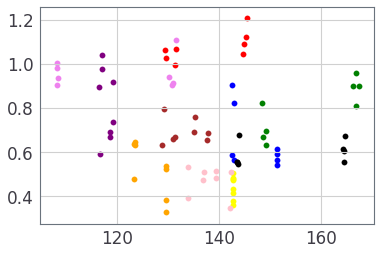

In [7]:
color_list = ['blue', 'green', 'red', 'yellow', 'orange', 'pink', 'violet', 'black', 'purple', 'brown']
for i in range(0, 10):
    plt.scatter(table['rmse_Qle'][i*8:(i+1)*8], table['d_Qle'][i*8:(i+1)*8], color=color_list[i])

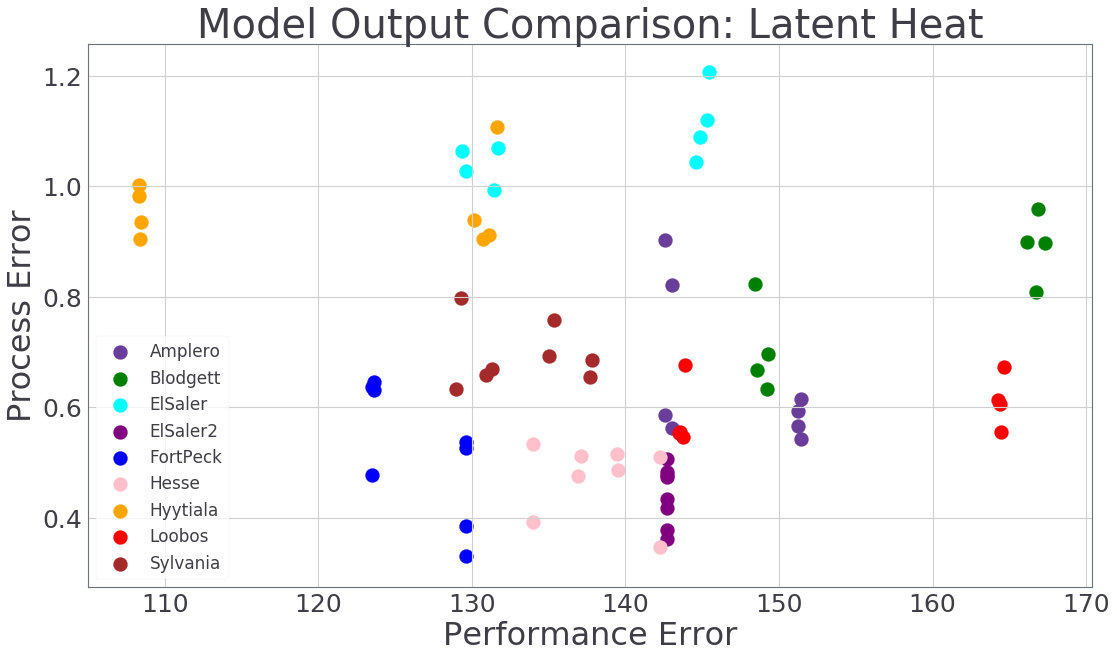

In [9]:
color_list = ['#6a3d9a', 'green', 'cyan', 'purple', 'blue', 'pink', 'orange', 'red', 'red', 'brown']
fig = plt.figure(figsize=(18,10))
plt.title('Model Output Comparison: Latent Heat', fontsize=40)
plt.xlabel('Performance Error', fontsize=32)
plt.ylabel('Process Error', fontsize=32)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#cbar = plt.colorbar(fig)
for i in [0, 1, 2, 3, 4, 5, 6, 7, 9]:
    if (i==7):
        plt.scatter(table['rmse_Qle'][i*8:(i+1)*8], table['d_Qle'][i*8:(i+1)*8], 
                    color=color_list[i], label=soil_moisture_sites[i], s=200,
                    marker='o')
    else:
        plt.scatter(table['rmse_Qle'][i*8:(i+1)*8], table['d_Qle'][i*8:(i+1)*8], 
                color=color_list[i], label=soil_moisture_sites[i], s=200)
plt.legend(loc='lower left')
#for t in cbar.get_yticklabels():
              #t.set_fontsize(20)
fig.savefig('../data/lat_heat_scatter.png')


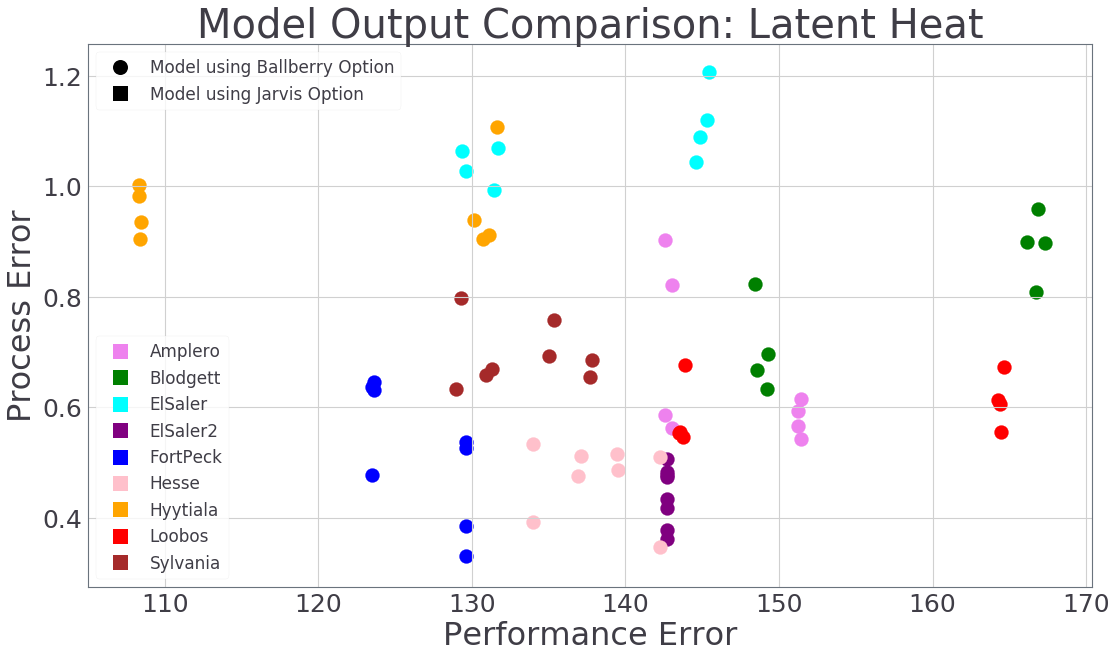

In [10]:
import matplotlib.patches as mpatches

color_list = ['violet', 'green', 'cyan', 'purple', 'blue', 'pink', 'orange', 'red', 'red', 'brown']
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)
plt.title('Model Output Comparison: Latent Heat', fontsize=40)
plt.xlabel('Performance Error', fontsize=32)
plt.ylabel('Process Error', fontsize=32)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#cbar = plt.colorbar(fig)
for i in [0, 1, 2, 3, 4, 5, 6, 7, 9]:
    if (i==7):
        ax.scatter(table['rmse_Qle'][i*8:(i+1)*8], table['d_Qle'][i*8:(i+1)*8], 
                    color=color_list[i], label=soil_moisture_sites[i], s=200,
                    marker='o')
    else:
        ax.scatter(table['rmse_Qle'][i*8:(i+1)*8], table['d_Qle'][i*8:(i+1)*8], 
                color=color_list[i], label=soil_moisture_sites[i], s=200)
        
red_patch = mpatches.Patch(color='red', label='The red data')

import matplotlib.lines as mlines
import matplotlib.pyplot as plt

jarvis_marker = mlines.Line2D([], [], linewidth=0, color='black', marker='s',
                          markersize=15, label='Model using Jarvis Option')
ballberry_marker = mlines.Line2D([], [], linewidth=0, color='black', marker='o',
                          markersize=15, label='Model using Ballberry Option')

legend_list = []
#legend_list.append(ballberry_marker)
#legend_list.append(jarvis_marker)

for i in [0, 1, 2, 3, 4, 5, 6, 7, 9]:
    legend_list.append(mlines.Line2D([], [], linewidth=0, color=color_list[i], 
                                     marker='s', markersize=15, 
                                     label=soil_moisture_sites[i]))
    
second_legend = plt.legend(handles = legend_list, loc = 'lower left')

#first_legend = plt.legend(loc='lower left')
plt.gca().add_artist(second_legend)


#plt.legend(handles=[blue_line])
plt.legend(handles=[ballberry_marker, jarvis_marker], loc='upper left')
#plt.legend(loc='lower left')
#for t in cbar.get_yticklabels():
              #t.set_fontsize(20)
fig.savefig('../data/lat_heat_scatter.png')


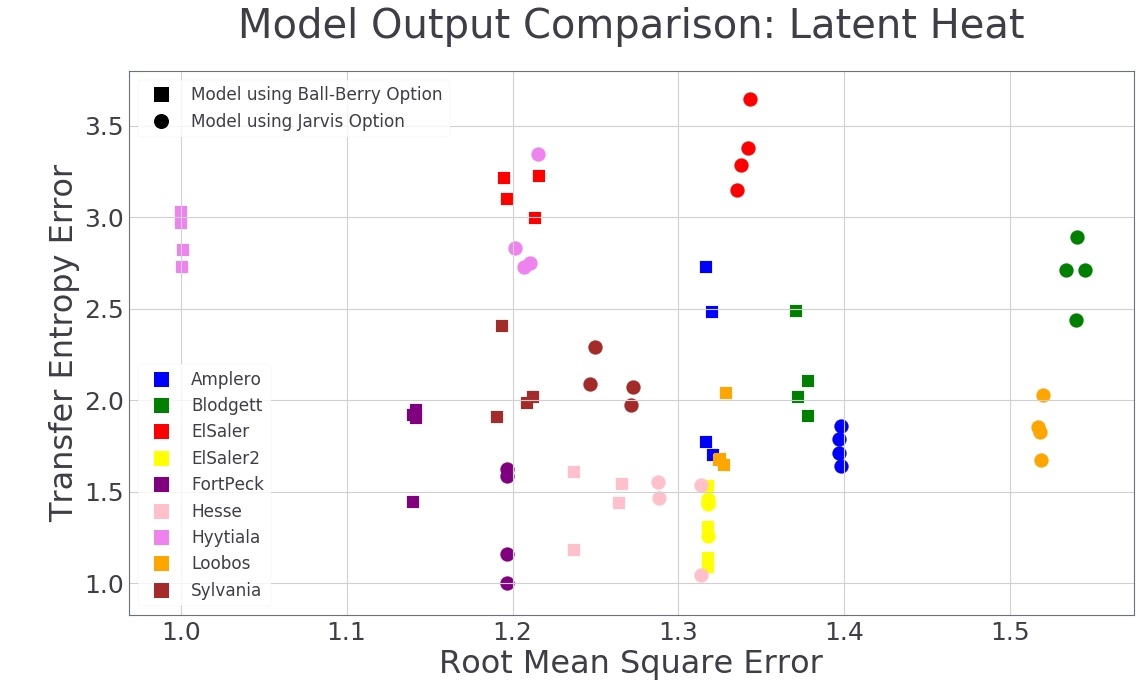

In [13]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

color_list = ['blue', 'green', 'red', 'yellow', 'purple', 
              'pink', 'violet', 'orange', 'purple', 'brown']
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)
plt.title('Model Output Comparison: Latent Heat', fontsize=40, y=1.05)
plt.xlabel('Root Mean Square Error', fontsize=32, y=10)
plt.ylabel('Transfer Entropy Error', fontsize=32)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#cbar = plt.colorbar(fig)

# find lowest rmse and mi dif values for scaling
low_rmse = min(table['rmse_Qle'])
low_diff = min(table['d_Qle'])
#low_diff = 0
'''for i in range(0, 80):
    if (i < 64 or i > 71):
        next_rmse = table['rmse_Qle'][i]
        next_diff = table['d_Qle'][i]
        low_rmse = math.min(low_rmse, next_rmse)
        low_diff = math.min(low_diff, next_diff)'''


for i in range(0, 80):
    if (i < 64 or i > 71):
        if 'Jarvis' in table['Configuration'][i]:
            plt.scatter(table['rmse_Qle'][i]/low_rmse, table['d_Qle'][i]/low_diff, 
                        color=color_list[i//8], 
                        s=200)
        elif 'BallBerry' in table['Configuration'][i]:
            plt.scatter(table['rmse_Qle'][i]/low_rmse, table['d_Qle'][i]/low_diff, 
                        color=color_list[i//8], s=150,
                        marker='s')
        
jarvis_marker = mlines.Line2D([], [], linewidth=0, color='black', marker='o',
                          markersize=15, label='Model using Jarvis Option')
ballberry_marker = mlines.Line2D([], [], linewidth=0, color='black', marker='s',
                          markersize=15, label='Model using Ball-Berry Option')

legend_list = []
#legend_list.append(ballberry_marker)
#legend_list.append(jarvis_marker)

for i in [0, 1, 2, 3, 4, 5, 6, 7, 9]:
    legend_list.append(mlines.Line2D([], [], linewidth=0, color=color_list[i], 
                                     marker='s', markersize=15, 
                                     label=soil_moisture_sites[i]))
    
second_legend = plt.legend(handles = legend_list, loc = 'lower left')

#first_legend = plt.legend(loc='lower left')
plt.gca().add_artist(second_legend)


#plt.legend(handles=[blue_line])
plt.legend(handles=[ballberry_marker, jarvis_marker], loc='upper left')
ax.annotate('This is awesome!', xy=(40, 40), fontsize=100)
#plt.legend(loc='lower left')
#for t in cbar.get_yticklabels():
              #t.set_fontsize(20)
fig.savefig('../data/lat_heat_scatter.png')


Text(40,40,'This is awesome!')

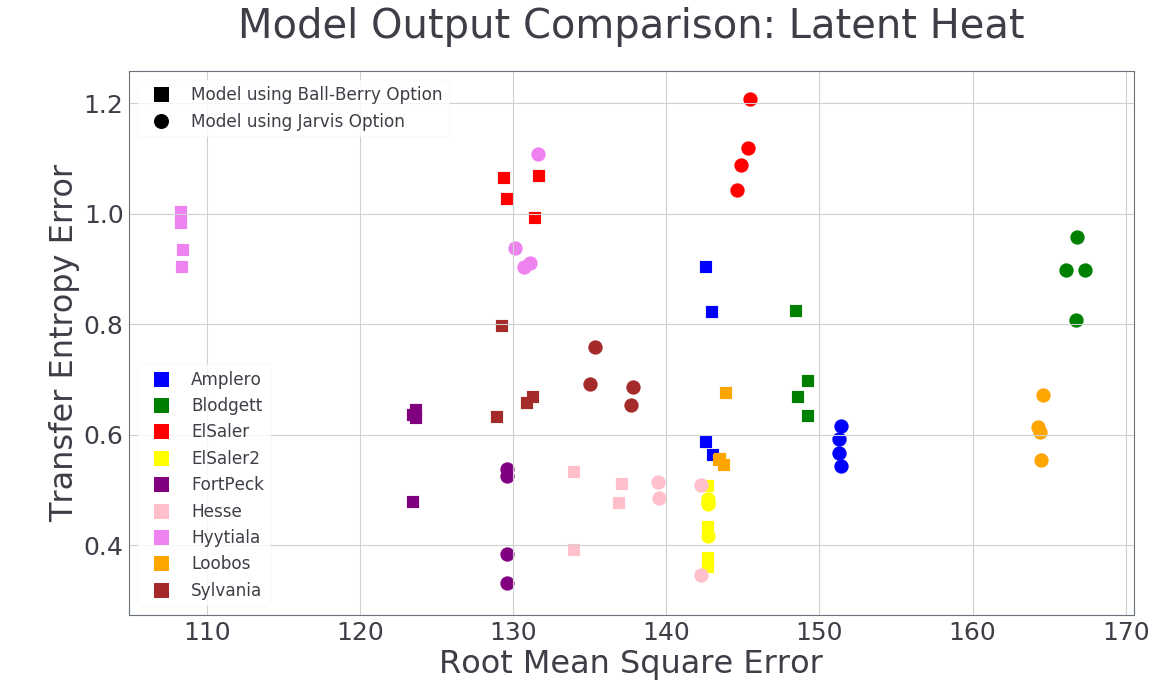

In [12]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

color_list = ['blue', 'green', 'red', 'yellow', 'purple', 
              'pink', 'violet', 'orange', 'purple', 'brown']
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)
plt.title('Model Output Comparison: Latent Heat', fontsize=40, y=1.05)
plt.xlabel('Root Mean Square Error', fontsize=32, y=10)
plt.ylabel('Transfer Entropy Error', fontsize=32)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#cbar = plt.colorbar(fig)
for i in range(0, 80):
    if (i < 64 or i > 71):
        if 'Jarvis' in table['Configuration'][i]:
            plt.scatter(table['rmse_Qle'][i], table['d_Qle'][i], 
                        color=color_list[i//8], 
                        s=200)
        elif 'BallBerry' in table['Configuration'][i]:
            plt.scatter(table['rmse_Qle'][i], table['d_Qle'][i], 
                        color=color_list[i//8], s=150,
                        marker='s')
        
jarvis_marker = mlines.Line2D([], [], linewidth=0, color='black', marker='o',
                          markersize=15, label='Model using Jarvis Option')
ballberry_marker = mlines.Line2D([], [], linewidth=0, color='black', marker='s',
                          markersize=15, label='Model using Ball-Berry Option')

legend_list = []
#legend_list.append(ballberry_marker)
#legend_list.append(jarvis_marker)

for i in [0, 1, 2, 3, 4, 5, 6, 7, 9]:
    legend_list.append(mlines.Line2D([], [], linewidth=0, color=color_list[i], 
                                     marker='s', markersize=15, 
                                     label=soil_moisture_sites[i]))
    
second_legend = plt.legend(handles = legend_list, loc = 'lower left')

#first_legend = plt.legend(loc='lower left')
plt.gca().add_artist(second_legend)


#plt.legend(handles=[blue_line])
plt.legend(handles=[ballberry_marker, jarvis_marker], loc='upper left')
ax.annotate('This is awesome!', xy=(40, 40), fontsize=100)
#plt.legend(loc='lower left')
#for t in cbar.get_yticklabels():
              #t.set_fontsize(20)
#fig.savefig('../data/lat_heat_scatter.png')


In [92]:
'Jarvis' in table['Configuration'][0]

True

No handles with labels found to put in legend.


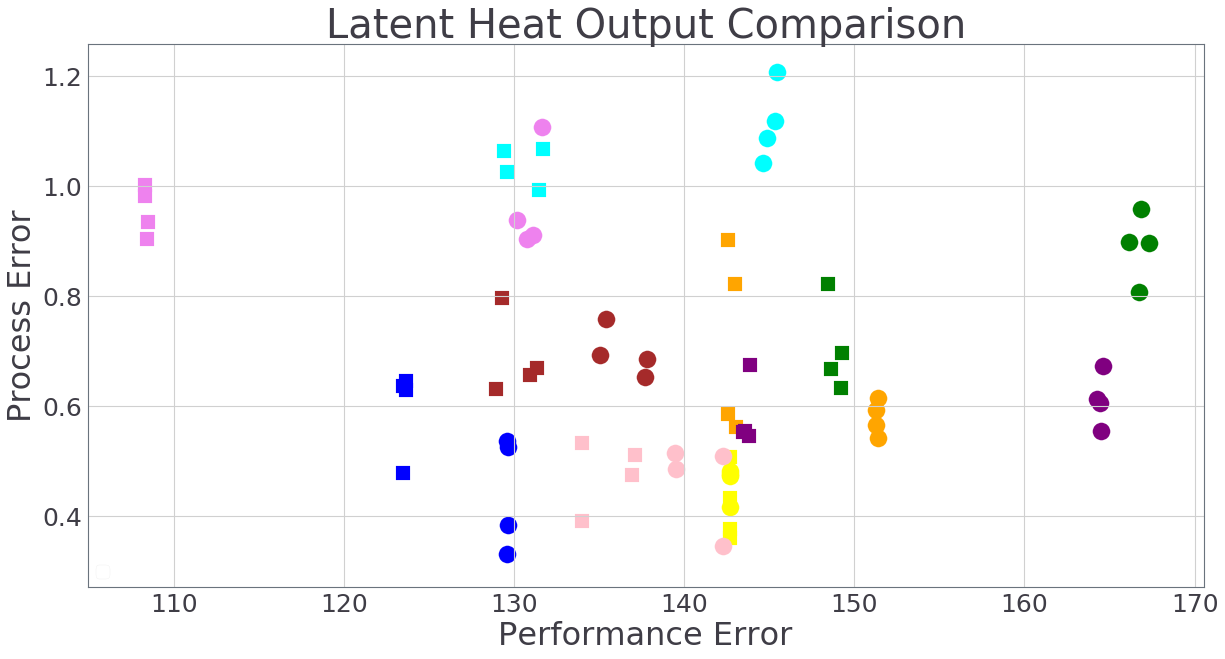

In [72]:
import matplotlib.lines as mlines
color_list = ['orange', 'green', 'cyan', 'yellow', 'blue', 'pink', 'violet', 'purple', 'red', 'brown']
fig = plt.figure(figsize=(20,10))
plt.title('Latent Heat Output Comparison', fontsize=40)
plt.xlabel('Performance Error', fontsize=32)
plt.ylabel('Process Error', fontsize=32)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#cbar = plt.colorbar(fig)
for i in range(0, 80):
    if (i < 64 or i > 71):
        if 'Jarvis' in table['Configuration'][i]:
            plt.scatter(table['rmse_Qle'][i], table['d_Qle'][i], 
                        color=color_list[i//8], 
                        s=300)
        elif 'BallBerry' in table['Configuration'][i]:
            plt.scatter(table['rmse_Qle'][i], table['d_Qle'][i], 
                        color=color_list[i//8], s=200,
                        marker='s')
        
blue_line = mlines.Line2D([], [], color='blue', marker='*',
            markersize=15, label='Blue stars')
plt.legend(['first', 'second'])
plt.legend(loc='lower left')
#for t in cbar.get_yticklabels():
              #t.set_fontsize(20)
fig.savefig('../data/lat_heat_scatter.png')

In [67]:
range(0, 2) + range(5, 7)

TypeError: unsupported operand type(s) for +: 'range' and 'range'

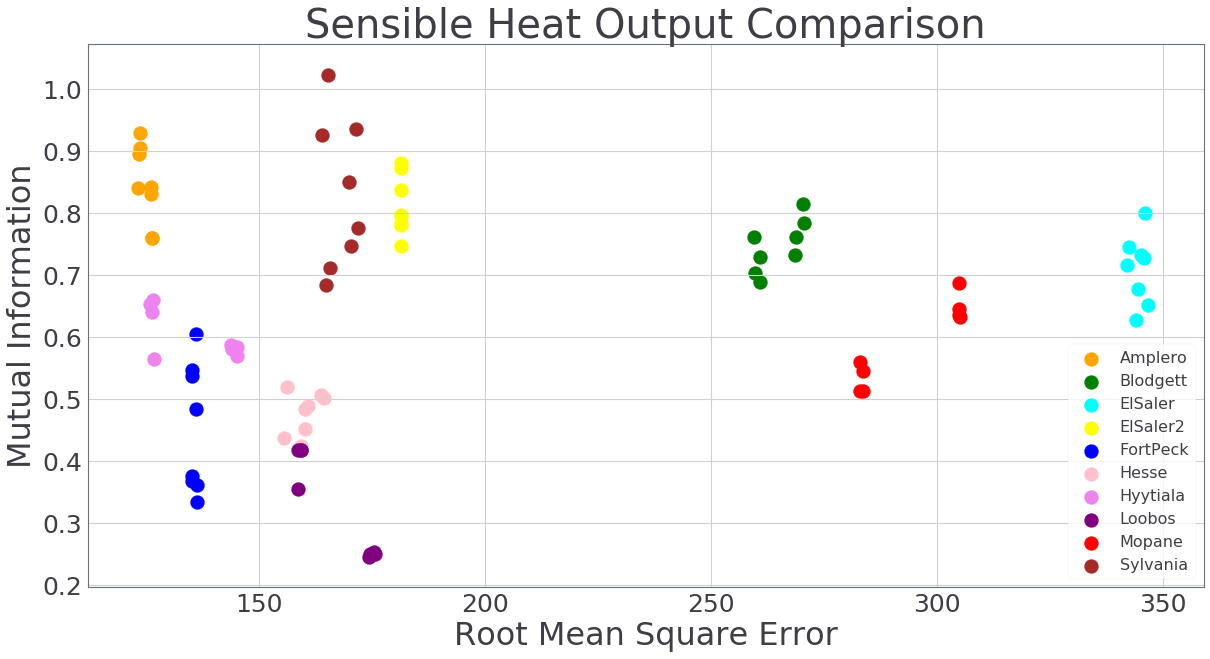

In [66]:
color_list = ['orange', 'green', 'cyan', 'yellow', 'blue', 'pink', 'violet', 'purple', 'red', 'brown']
fig = plt.figure(figsize=(20,10))
plt.title('Sensible Heat Output Comparison', fontsize=40)
plt.xlabel('Root Mean Square Error', fontsize=32)
plt.ylabel('Mutual Information', fontsize=32)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
for i in range(0, 10):
    plt.scatter(table['rmse_Qh'][i*8:(i+1)*8], table['d_Qh'][i*8:(i+1)*8], 
                color=color_list[i], label=soil_moisture_sites[i], s=200)
plt.legend(loc='best', fontsize=16)
fig.savefig('../data/sen_heat_scatter.png')

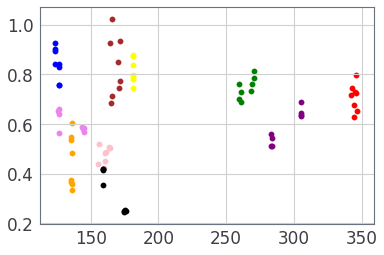

In [8]:
color_list = ['blue', 'green', 'red', 'yellow', 'orange', 'pink', 'violet', 'black', 'purple', 'brown']
for i in range(0, 10):
    plt.scatter(table['rmse_Qh'][i*8:(i+1)*8], table['d_Qh'][i*8:(i+1)*8], color=color_list[i])

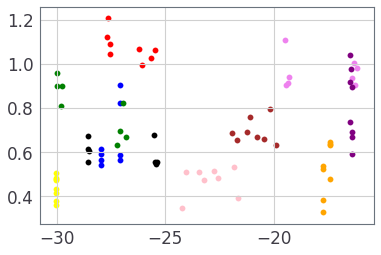

In [9]:
color_list = ['blue', 'green', 'red', 'yellow', 'orange', 'pink', 'violet', 'black', 'purple', 'brown']
for i in range(0, 10):
    plt.scatter(table['mbe_Qle'][i*8:(i+1)*8], table['d_Qle'][i*8:(i+1)*8], color=color_list[i])

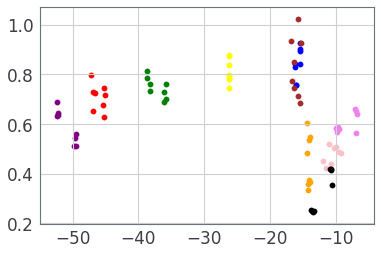

In [10]:
color_list = ['blue', 'green', 'red', 'yellow', 'orange', 'pink', 'violet', 'black', 'purple', 'brown']
for i in range(0, 10):
    plt.scatter(table['mbe_Qh'][i*8:(i+1)*8], table['d_Qh'][i*8:(i+1)*8], color=color_list[i])

Find how decisions affect things: site ElSaler

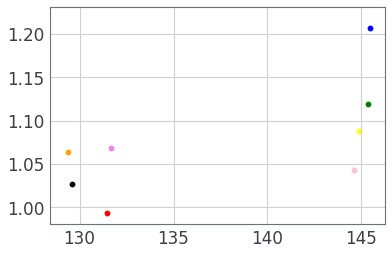

In [11]:
#color_list = ['blue', 'green', 'red', 'yellow', 'orange', 'pink', 'violet', 'black', 'purple', 'brown']
for i in range(0, 8):
    plt.scatter(table['rmse_Qle'][2*8+i], table['d_Qle'][2*8+i], color=color_list[i])

Decision Jarvis vs Ballberry

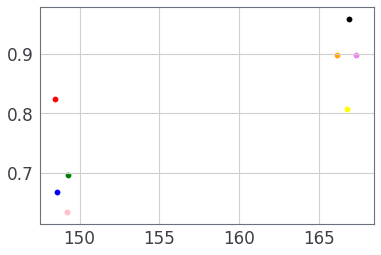

In [12]:
#color_list = ['blue', 'green', 'red', 'yellow', 'orange', 'pink', 'violet', 'black', 'purple', 'brown']
for i in range(0, 8):
    plt.scatter(table['rmse_Qle'][7*8+i], table['d_Qle'][7*8+i], color=color_list[i])

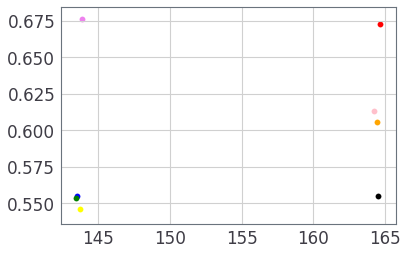

In [13]:
#color_list = ['blue', 'green', 'red', 'yellow', 'orange', 'pink', 'violet', 'black', 'purple', 'brown']
for i in range(0, 8):
    plt.scatter(table['rmse_Qle'][7*8+i], table['d_Qle'][7*8+i], color=color_list[i])

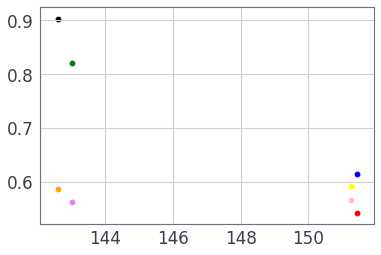

In [81]:
color_list = ['blue', 'green', 'red', 'yellow', 'orange', 'pink', 'violet', 'black', 'purple', 'brown']
for i in range(0, 8):
    plt.scatter(table['rmse_Qle'][0*8+i], table['d_Qle'][0*8+i], color=color_list[i])

In [82]:
table[:8]

,Unnamed: 0,Site,Configuration,rmse_Qle,mbe_Qle,d_Qle,rmse_Qh,mbe_Qh,d_Qh
0,0,Amplero,"['simplExp', 'exponential', 'Jarvis']",151.417550,-27.971468,0.615459,123.447173,-15.458641,0.895193
1,1,Amplero,"['simplExp', 'exponential', 'BallBerry']",143.009881,-27.104298,0.821685,126.189981,-16.192109,0.830636
2,2,Amplero,"['simplExp', 'logBelowCanopy', 'Jarvis']",151.416641,-27.986737,0.542856,123.424708,-15.451101,0.840091
3,3,Amplero,"['difTrans', 'logBelowCanopy', 'Jarvis']",151.267979,-27.968838,0.592969,123.753431,-15.366431,0.927825
4,4,Amplero,"['difTrans', 'exponential', 'BallBerry']",142.598461,-27.071725,0.586326,126.407864,-16.118417,0.758700
5,5,Amplero,"['difTrans', 'exponential', 'Jarvis']",151.268033,-27.972089,0.566546,123.748064,-15.364187,0.903670
6,6,Amplero,"['simplExp', 'logBelowCanopy', 'BallBerry']",143.028021,-27.111689,0.562820,126.198816,-16.194162,0.841371
7,7,Amplero,"['difTrans', 'logBelowCanopy', 'BallBerry']",142.598434,-27.071850,0.902916,126.407652,-16.118355,0.759217
